Необходимо разработать модель, которая определит жанр музыкального альбома по изображению его обложки.

1. Загрузим и ознакомимся с данными
2. Построим несколько нейросетей с разной архитектурой и параметрами. Определим лучшие характеристики
3. Построим итоговую модель и проанализируем результаты
5. Напишем выводы

## Загрузка и описание данных

Загрузим данных и ознакомимся с ними.

In [ ]:
from google.colab import drive
drive.mount("/content/drive")


Mounted at /content/drive


In [ ]:
from fastai.vision.all import *
from fastai.text.all import *
from fastai.collab import *
from fastai.tabular.all import *

In [ ]:
RS = 8
random.seed(RS)
np.random.seed(RS)
torch.manual_seed(RS)
torch.cuda.manual_seed(RS)
torch.cuda.manual_seed_all(RS)

Создадим датафрейм с адресом обложек и присвоенным музыкальным жанром.

In [ ]:
def get_file_paths(directory):
    return [os.path.join(root, filename) for root, _, files in os.walk(directory) for filename in files]

df_file_paths = get_file_paths('/content/drive/My Drive/Music_CV/')
df_file_paths = pd.DataFrame(df_file_paths, columns=['picture_address'])
df_file_paths.head(5)

picture_address
0  /content/drive/My Drive/Music_CV/anime/27ef5cea-7846-4263-86e2-a3862a164f7f.png
1  /content/drive/My Drive/Music_CV/anime/bce5481a-5f76-4a5e-9661-89b4ebfcc71e.png
2  /content/drive/My Drive/Music_CV/anime/5282cfb9-2fb6-4e25-b13b-f715cb16c6ad.png
3  /content/drive/My Drive/Music_CV/anime/94c63ae1-8b3c-4e21-9b63-74ee0d4e2293.png
4  /content/drive/My Drive/Music_CV/anime/f1844a42-d392-3c32-860f-026470c092c9.png

In [ ]:
df_file_paths['genre'] = 0
df_file_paths['genre'] = df_file_paths['picture_address'].str.extract(r'(?<=Music_CV\/)(.+)\/')
df_file_paths.head()

picture_address  \
0  /content/drive/My Drive/Music_CV/anime/27ef5cea-7846-4263-86e2-a3862a164f7f.png   
1  /content/drive/My Drive/Music_CV/anime/bce5481a-5f76-4a5e-9661-89b4ebfcc71e.png   
2  /content/drive/My Drive/Music_CV/anime/5282cfb9-2fb6-4e25-b13b-f715cb16c6ad.png   
3  /content/drive/My Drive/Music_CV/anime/94c63ae1-8b3c-4e21-9b63-74ee0d4e2293.png   
4  /content/drive/My Drive/Music_CV/anime/f1844a42-d392-3c32-860f-026470c092c9.png   

   genre  
0  anime  
1  anime  
2  anime  
3  anime  
4  anime

In [ ]:
df_file_paths.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7800 entries, 0 to 7799
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   picture_address  7800 non-null   object
 1   genre            7800 non-null   object
dtypes: object(2)
memory usage: 122.0+ KB


Всего 7800 обложек. Посмотрим, какие жанры содержаться в нашей базе.

genre
country        1486
anime          1189
classical       955
jazz            821
pop             803
edm             719
reggae          581
disco           468
black metal     450
rap             328
Name: genre, dtype: int64

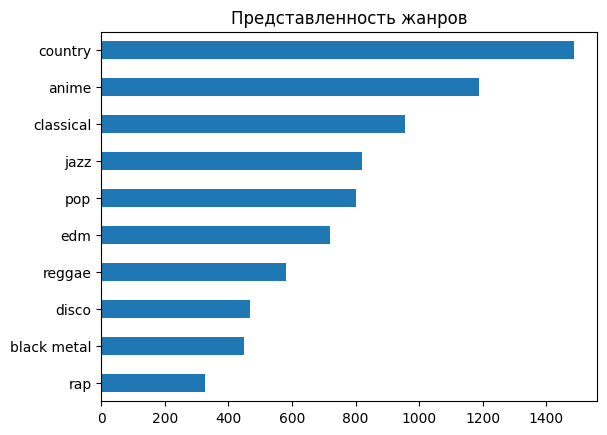

In [ ]:
df_file_paths.groupby('genre')['genre'].count().sort_values(ascending=True).plot(kind='barh', title = 'Представленность жанров')
plt.ylabel("")
df_file_paths.groupby('genre')['genre'].count().sort_values(ascending=False)

Всего 10 жанров. При этом представлены они неравномерно. Больше всего обложек жанра кантри (1486). Также много альбомов жанра аниме (1189) и классической музыки (955). Меньше всего - диско (468), black metal (450) и rap (328).

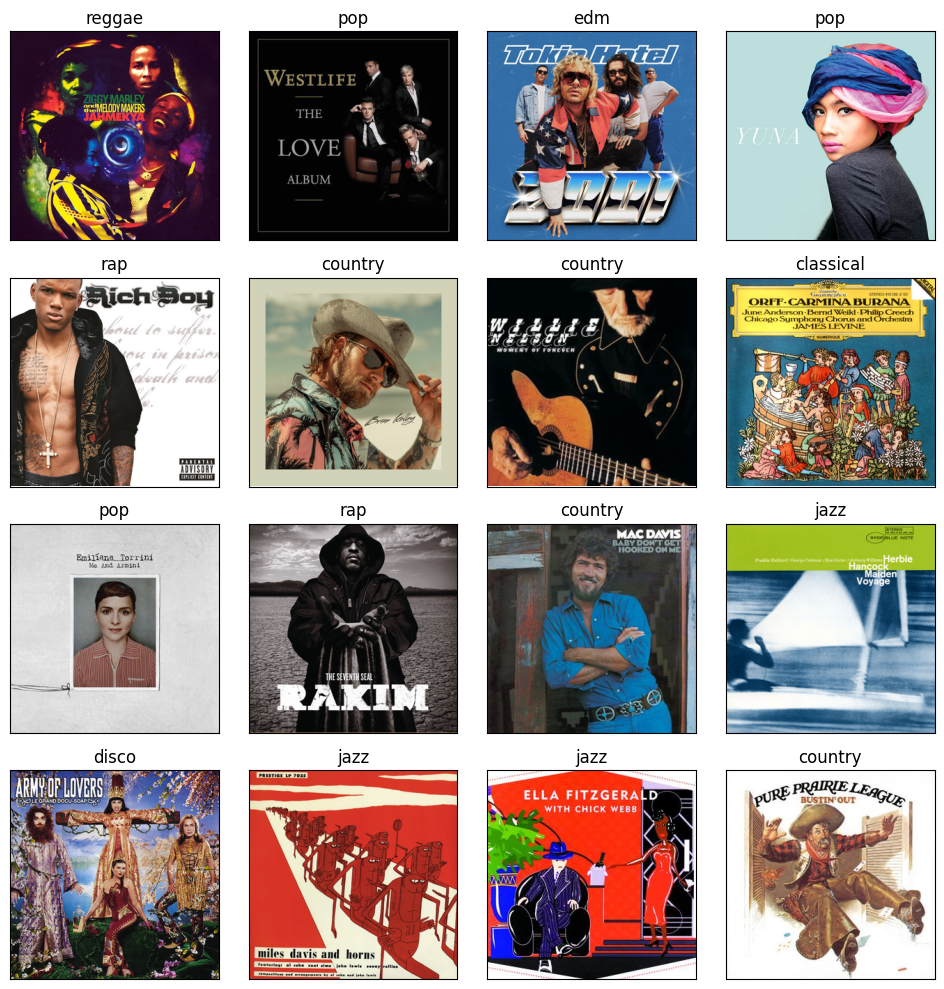

In [ ]:
fig = plt.figure(figsize=(10,10))
show_data = df_file_paths.sample(16)

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1)
    img_path = show_data['picture_address'].iloc[i]
    img = Image.open(img_path)
    plt.imshow(img)
    plt.title(str(show_data['genre'].iloc[i]), color='black')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

plt.show()

## Построение нейросети - ResNet18, ResNet34, ResNet50, ResNet101

Рассмотрим, какие результаты показывают архитектуры ResNet18, ResNet34, ResNet50, ResNet101.

Для каждой нейросети были применены одинаковые характеристики - кол-во эпох 10, размер батча 64 (по умолчанию), learning rate 0.001, применена нормализация. Все вычисления производились с помощью библиотеки FastAI.

Загруженные веса не применялись, так как в самом начале модели показали лучшее качество, обучаясь заново.

В качестве основной метрики, которая будет оценивать результат, будет Accuracy.

Максимальные значения Accuracy были следующие:

Архитектура | Accuracy (макс.)
--- | ---
ResNet18 | 65.3
ResNet34 | 65.6
ResNet50 | 70.1
ResNet101 | 70.3

Для дальнейшей работы была выбрана архитектура ResNet50, так как она показала хорошие результаты. Более сложная ResNet101 показала результат лишь немного лучше, чем ResNet50. Из-за сложности вычислений не будем далее ее применять.

## Размер батча

Для модели ResNet50 было увеличено количество эпох до 20, так как функция потерь не уменьшалась так же стремительно, как в более "простых" моделях ResNet18 и ResNet34, и важно было проследить, что модель обучилась и как ведут себя метрики в процессе обучения.

Далее менялся размер батча - увеличен до 90 и уменьшен до 50. Результаты:

Размер батча | Accuracy (макс.)
--- | ---
64 (по умолчанию) | 70.1
90 | 71.4
50 | 71.5


Лучший результат показал размер батча 50. Он ненамного лучше, чем размер в 90 картинок, но из-за сложности вычислений оставим размер батча, равным 50.

## learning rate - скорость обучения

Ранее скорость обучения (learning rate) стояла по умолчанию и была равна 0.001.

Проверим, изменится ли результат, если сделать learning rate, равным 0.01. Другие параметры оставим такими же - архитектура ResNet50 без предобученных весов, размер батча 50, 20 эпох обучения.

lr | Accuracy (макс.)
--- | ---
0.001 (по умолчанию) | 71.5
0.01 | 72.2


Увеличение скорости обучения дало прирост качества прогноза, воспользуемся значением 0.01 далее.

## Аугментация

Качество предсказания выделенных жанров неравномерно - какие-то жанры определяются лучше, какие-то хуже. Возможно, применение аугметации сможет частично решить эту проблему, так как у нейросети появится больше разнообразных данных для обучения.

Аугментация | Accuracy (макс.)
--- | ---
Нет | 72.2
Есть | 73.0

Использование аугментации улучшило качество прогноза.

Построим итоговую модель с учетом удачных преобразований модели.

## Итоговая модель

Построим итоговую модель со следующими характеристиками:

архитектура ResNet50 без предобученных весов,

размер батча 50,

20 эпох обучения,

learning rate 0.01,

применена аугментация,

размер тестовой выборки 20%

In [ ]:
path = '/content/drive/MyDrive/Music_CV/'

In [ ]:
dls = ImageDataLoaders.from_folder(path, valid_pct=0.2, seed=12345, bs=50, batch_tfms=aug_transforms(flip_vert=True))

In [ ]:
dls.valid_ds.items[:3]

[Path('/content/drive/MyDrive/Music_CV/pop/894d25fb-ed97-4f87-8190-d30ae26ddcd0.png'),
 Path('/content/drive/MyDrive/Music_CV/pop/9a08c8ed-4fc1-440a-a0ef-f635635a06a0.png'),
 Path('/content/drive/MyDrive/Music_CV/jazz/40e3e022-f4b7-441d-b1d3-2873a89ffc25.png')]

In [ ]:
len(dls.valid_ds)

1560

In [ ]:
len(dls.train_ds)

6240

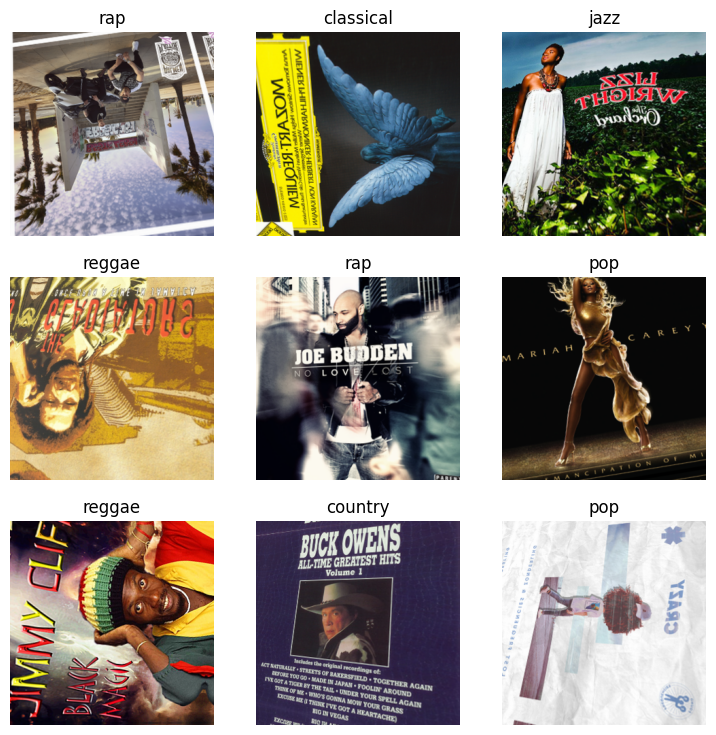

In [ ]:
dls.show_batch()

In [ ]:
ResNet50_CV = vision_learner(dls, models.resnet50, normalize=True, \
                             lr=0.01,
                             metrics=[accuracy, Precision(average='weighted'), Recall(average='weighted'), F1Score(average='weighted')]
)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 160MB/s]


In [ ]:
ResNet50_CV.fine_tune(20)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os

Максимальное значение Accuracy достигает 73%. При этом фнкция потерь на тренировочной выборке постоянно уменьшается. На тестовой - сначала уменьшается, потом начинает увеличиваться, что указывает на то, что модель начинает переобучаться.

Построим матрицу ошибок (нормализованную) и посмотрим, какие жанры определяются хуже или лучше.

In [ ]:
interp50 = ClassificationInterpretation.from_learner(ResNet50_CV)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


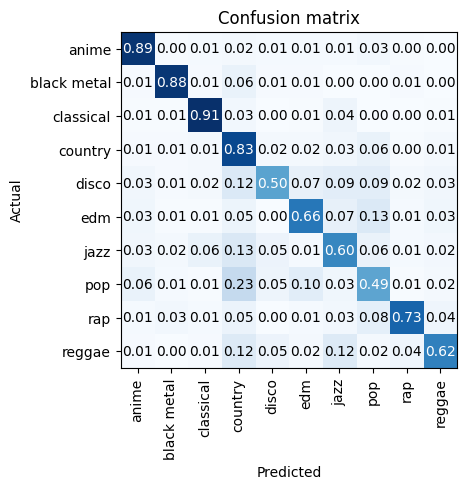

In [ ]:
interp50.plot_confusion_matrix(normalize=True)

Наиболее точно модель определяет жанры anime, black metal, classical, country, rap.

Хуже всего - disco, pop, edm, jazz, reggae.

При этом жанр country ошибочно присваивается многим другим жанрам.

In [ ]:
preds, target, losses = ResNet50_CV.get_preds(with_loss=True)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Выведем несколько случайных примеров и посмотрим, правильно ли они предсказались.

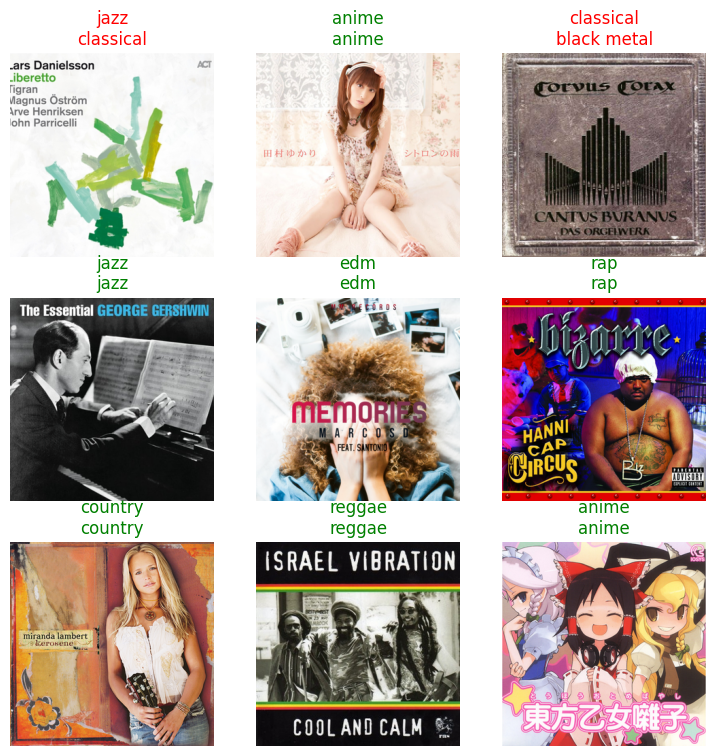

In [ ]:
ResNet50_CV.show_results()

В примере выше есть два примера с неправильным предсказанием. Это первая обложка, которая относится к жанру классической музыки, но нейросеть определила ее как джаз. Возможно, из-за необычного рисунка мазками на обложке, который менее характерен для альбомов классической музыки.

И второй пример - альбом исполнителя, который исполняет музыку в стиле black metal. Но модель определила его как classic. Скорее всего это произошло из-за того, что на обложке нарисован орган и она действительно похожа на альбом классической музыки.

Посмотрим больше примеров, где модель ошибается. Выведем топ-5 самых ошибочных примеров.

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


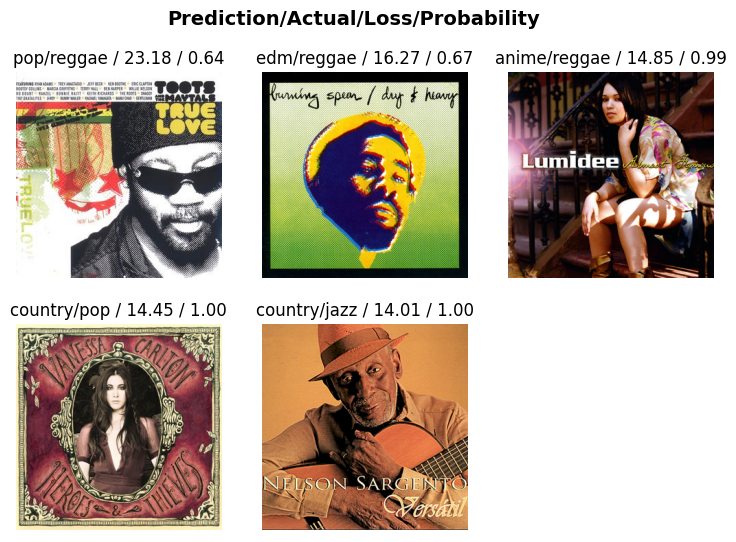

In [ ]:
interp50.plot_top_losses(5)

Пятая обложка в самом низу - мужчина обнимает гитару. Nelson Sargento  - латиноамериканский исполнитель, его альбом в нашей базе данных обозначен как джаз. Модель определила его как кантри направление. Скорее всего, это произошло из-за изображения человека классической гитары на обложке.

Четвертая обложка - исполнительницы поп-музыки Vanessa Carlton. Модель определила этот альбом как кантри-музыку. Скорее всего, это произошло из-за несвойственного поп-альбомам обрамления на обложке в виде узоров и закруглений.

Самая правая обложка в первом ряду определилась нейросетью как жанр аниме, но на самом деле женщина на обложке исполняет музыку в стиле регги.

Первые две обложки в первом ряду тоже относятся к стилю регги, хотя модель определила жанры pop и edm.

## Итоги

Всего у нас есть 7800 изображений обложек 10 музыкальных жанров.
Для определения принадлежности к музыкальному жанру были расммотрены архитектуры нейросетей ResNet18, ResNet34, ResNet50, ResNet101. Оптимальной по соотношению трудоемкости вычислений и качеству была выбрана ResNet50. Итоговая модель вычислялась по следующим характеристикам:

архитектура ResNet50 без предобученных весов,

размер батча 50,

20 эпох обучения,

learning rate 0.01,

применена аугментация,

размер тестовой выборки 20%


Итоговое качество модели получилось (Accuracy) почти 73%.


Наиболее точно модель определяет жанры anime, black metal, classical, country, rap.

Хуже всего - disco, pop, edm, jazz, reggae.

При этом жанр country ошибочно присваивается многим другим жанрам.

Для более точного предсказания, возможно, следует добавить дополнительную информацию - анализ текста на обложке и на обратной стороне обложки.

Некоторые неправильно предсказанные обложки трудно определяются человеком - артист может исполнять музыку одного жанра, а обложка более характерна для другого (например, фото органа и других классических инструментов на обложках других жанров "путает" модель, да и человеку, без знания исполнителя трудно догадаться о действительном жанре альбома).

Поэтому, если исполнители хотят, чтобы обложки их альбомов хорошо распознавались автоматическими системам, им следует ознакомится с уже существующими обложками определенных жанров, и делать свою обложку с похожими элементами, не внося элементы других жанров.